## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from skimage import io
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from skimage.io import imread

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
# Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
52218,00013178_005.png,No Finding,5,13178,27,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00013178_005.png
16950,00004543_000.png,No Finding,0,4543,45,F,PA,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004543_000.png
75235,00018464_000.png,Infiltration,0,18464,57,F,PA,2048,2500,0.168,0.168,NaN,/data/images_009/images/00018464_000.png


In [3]:
# Examine the distribution
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [4]:
# Discard unnecessary columns
d = all_xray_df.drop(columns=['Follow-up #', 'Unnamed: 11'], axis=1)

The `Patient Age` column seems to have erroneous data. Let's discard unrealistic age data points as well as the extreme age values, so that the images area bit more consistent for the model to work with.

In [5]:
# Retain data where patient age is between 16 and 90
d = d[(d['Patient Age'] >= 16) & (d['Patient Age'] <= 90)]

In [6]:
# Create separate disease label columns from "Finding Labels" column with binary encoding
all_labels = np.unique(list(chain(*list(map(lambda x: x.split('|'), d['Finding Labels'].unique())))))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    d[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
d.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
75110,00018427_001.png,Infiltration,18427,64,M,PA,2500,2048,0.168,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
97740,00025787_063.png,No Finding,25787,28,M,AP,3056,2544,0.139,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
76919,00018888_000.png,No Finding,18888,38,F,PA,2048,2500,0.168,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

d['pneumonia_class'] = d.Pneumonia.replace({0.0:'Negative',1.0:'Positive'})

In [8]:
d[d['pneumonia_class'] == 'Positive']

,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,13,60,M,AP,3056,2544,0.139,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,32,55,F,AP,2500,2048,0.168,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
253,00000056_000.png,Nodule|Pneumonia,56,76,M,PA,2500,2048,0.168,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,61,77,M,AP,3056,2544,0.139,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Positive
279,00000061_015.png,Pneumonia,61,77,M,AP,3056,2544,0.139,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,30536,56,F,AP,3056,2544,0.139,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111627,00030570_001.png,Edema|Infiltration|Pneumonia,30570,29,F,AP,3056,2544,0.139,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111767,00030621_002.png,Pneumonia,30621,22,F,AP,3056,2544,0.139,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111845,00030637_016.png,Consolidation|Pneumonia,30637,48,M,AP,3056,2544,0.139,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive


## Create your training and testing data:

In [9]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['pneumonia_class'])
    # Make training dataset to have 50-50% balance in Pneumonia class
    p_inds = train_data[train_data.pneumonia_class == 'Positive'].index.tolist()
    np_inds = train_data[train_data.pneumonia_class == 'Negative'].index.tolist()
    random.seed(42)
    np_sample = random.sample(np_inds, len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    p_inds = val_data[val_data.pneumonia_class == 'Positive'].index.tolist()
    np_inds = val_data[val_data.pneumonia_class == 'Negative'].index.tolist()
    # Here we make an assumption that in the actual clinical setting where we want to deploy the algorithm,
    # the prevalence of Pneumonia will be about 20%. This is because patients are only being x-rayed based
    # on their clinical symptoms that make Pneumonia highly likely.
    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    random.seed(42)
    np_sample = random.sample(np_inds, 4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    return train_data, val_data

In [10]:
train, val = create_splits(d)

In [11]:
# Check positive and negative case count in training set
(train['pneumonia_class'] == 'Positive').value_counts()

True     1077
False    1077
Name: pneumonia_class, dtype: int64

In [12]:
# Check positive and negative case count in validation set
(val['pneumonia_class'] == 'Positive').value_counts()

False    1076
True      269
Name: pneumonia_class, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
def my_image_augmentation(is_train=True):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    if is_train:
        my_idg = ImageDataGenerator(samplewise_center=True,
                                    samplewise_std_normalization=True,
                                  horizontal_flip=True, 
                                  vertical_flip=False, 
                                  height_shift_range=0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=20, 
                                  shear_range=0.1,
                                  zoom_range=0.1)
    else:
        my_idg = ImageDataGenerator(samplewise_center=True,
                                samplewise_std_normalization=True,
                                   )
    
    return my_idg


def make_train_gen(idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col='path',
                                         y_col='pneumonia_class',
                                         class_mode='binary',
                                         target_size=(224, 224), 
                                         batch_size=64
                                         )
    return gen


def make_val_gen(idg, val_df):
    gen = idg.flow_from_dataframe(dataframe=val_df, 
                                             directory=None, 
                                             x_col='path',
                                             y_col='pneumonia_class',
                                             class_mode='binary',
                                             target_size=(224, 224), 
                                             batch_size=128
                                         ) 
    return gen

In [14]:
train_idg = my_image_augmentation()
val_idg = my_image_augmentation(False)

In [15]:
train_gen = make_train_gen(train_idg, train)
val_gen = make_val_gen(val_idg, val)

Found 2154 validated image filenames belonging to 2 classes.
Found 1345 validated image filenames belonging to 2 classes.


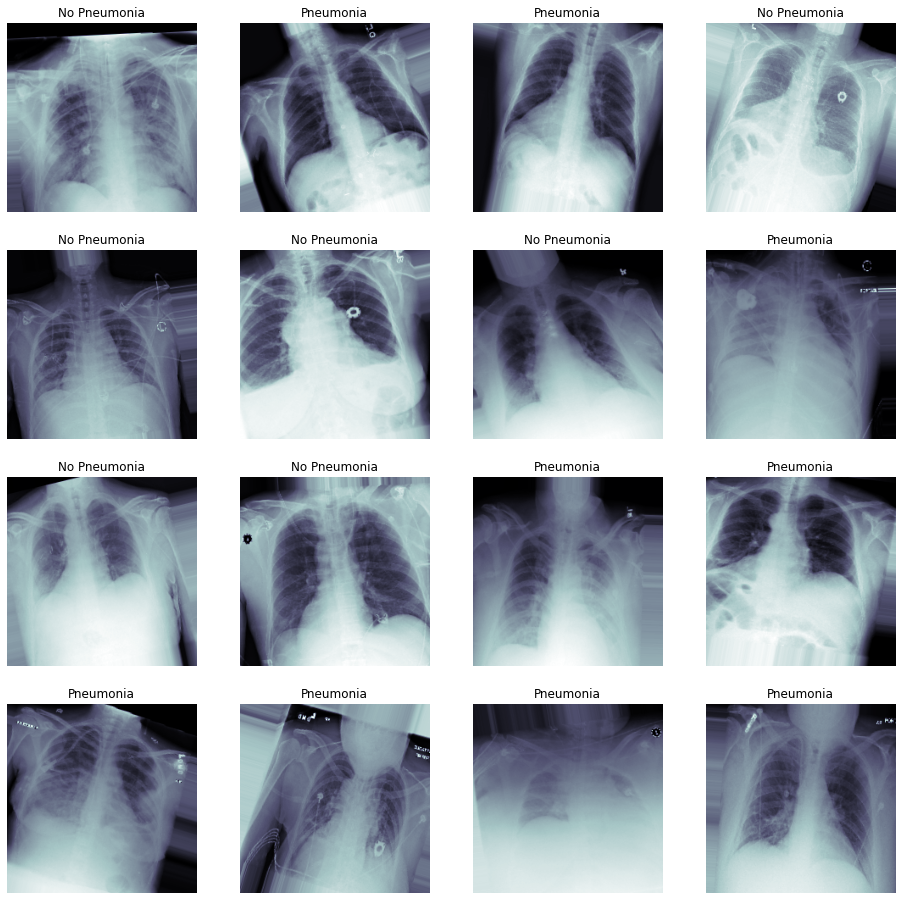

In [16]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data looks prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [17]:
def load_pretrained_model():
    pretrained_model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = pretrained_model.get_layer('block5_pool')
    vgg_model = Model(inputs=pretrained_model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [18]:
def build_my_model1():
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    vgg_model = load_pretrained_model()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [19]:
def build_my_model2():
    my_model = Sequential()
    vgg_model = load_pretrained_model()
    my_model.add(vgg_model)
    my_model.add(Dropout(0.4))
    my_model.add(Flatten())
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

In [20]:
def build_my_model3():
    my_model = Sequential()
    vgg_model = load_pretrained_model()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.4))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.4))
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

In [21]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting
def get_weight_path_and_callbacks_list(model_num):
    
    weight_path = "xray_class_my_model{}.best.hdf5".format(model_num)

    checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

    early = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          patience=10)

    callbacks_list = [checkpoint, early]
    return weight_path, callbacks_list

### Start training! 

In [22]:
model1 = build_my_model1()
weight_path1, callbacks_list1 = get_weight_path_and_callbacks_list(1)
history1 = model1.fit_generator(train_gen, 
                          validation_data=val_gen, 
                          epochs=20, 
                          callbacks=callbacks_list1)

553467904/553467096 [==============================] - 5s 0us/step
Epoch 1/20
34/34 [==============================] - 91s 3s/step - loss: 0.6952 - binary_accuracy: 0.5590 - val_loss: 0.5872 - val_binary_accuracy: 0.6312

Epoch 00001: val_loss improved from inf to 0.58717, saving model to xray_class_my_model1.best.hdf5
Epoch 2/20
34/34 [==============================] - 52s 2s/step - loss: 0.6484 - binary_accuracy: 0.6212 - val_loss: 0.5686 - val_binary_accuracy: 0.6431

Epoch 00002: val_loss improved from 0.58717 to 0.56863, saving model to xray_class_my_model1.best.hdf5
Epoch 3/20
34/34 [==============================] - 60s 2s/step - loss: 0.6379 - binary_accuracy: 0.6360 - val_loss: 0.6099 - val_binary_accuracy: 0.6840

Epoch 00003: val_loss did not improve from 0.56863
Epoch 4/20
34/34 [==============================] - 60s 2s/step - loss: 0.6204 - binary_accuracy: 0.6555 - val_loss: 0.7179 - val_binary_accuracy: 0.6164

Epoch 00004: val_loss did not improve from 0.56863
Epoch 5/2

In [23]:
model2 = build_my_model2()
weight_path2, callbacks_list2 = get_weight_path_and_callbacks_list(2)
history2 = model2.fit_generator(train_gen, 
                          validation_data=val_gen, 
                          epochs=20, 
                          callbacks=callbacks_list2)

Epoch 1/20
34/34 [==============================] - 70s 2s/step - loss: 0.7422 - binary_accuracy: 0.5427 - val_loss: 0.6301 - val_binary_accuracy: 0.6706

Epoch 00001: val_loss improved from inf to 0.63011, saving model to xray_class_my_model2.best.hdf5
Epoch 2/20
34/34 [==============================] - 62s 2s/step - loss: 0.6897 - binary_accuracy: 0.6021 - val_loss: 0.5491 - val_binary_accuracy: 0.7271

Epoch 00002: val_loss improved from 0.63011 to 0.54914, saving model to xray_class_my_model2.best.hdf5
Epoch 3/20
34/34 [==============================] - 61s 2s/step - loss: 0.6686 - binary_accuracy: 0.6188 - val_loss: 0.5911 - val_binary_accuracy: 0.6833

Epoch 00003: val_loss did not improve from 0.54914
Epoch 4/20
34/34 [==============================] - 60s 2s/step - loss: 0.6506 - binary_accuracy: 0.6314 - val_loss: 0.5686 - val_binary_accuracy: 0.6387

Epoch 00004: val_loss did not improve from 0.54914
Epoch 5/20
34/34 [==============================] - 60s 2s/step - loss: 0.64

In [24]:
model3 = build_my_model3()
weight_path3, callbacks_list3 = get_weight_path_and_callbacks_list(3)
history3 = model3.fit_generator(train_gen, 
                          validation_data=val_gen, 
                          epochs=20, 
                          callbacks=callbacks_list3)

Epoch 1/20
34/34 [==============================] - 70s 2s/step - loss: 0.7348 - binary_accuracy: 0.5292 - val_loss: 0.7301 - val_binary_accuracy: 0.4260

Epoch 00001: val_loss improved from inf to 0.73009, saving model to xray_class_my_model3.best.hdf5
Epoch 2/20
34/34 [==============================] - 60s 2s/step - loss: 0.6837 - binary_accuracy: 0.5799 - val_loss: 0.5693 - val_binary_accuracy: 0.6922

Epoch 00002: val_loss improved from 0.73009 to 0.56928, saving model to xray_class_my_model3.best.hdf5
Epoch 3/20
34/34 [==============================] - 60s 2s/step - loss: 0.6681 - binary_accuracy: 0.5952 - val_loss: 0.6642 - val_binary_accuracy: 0.5428

Epoch 00003: val_loss did not improve from 0.56928
Epoch 4/20
34/34 [==============================] - 59s 2s/step - loss: 0.6495 - binary_accuracy: 0.6235 - val_loss: 0.6492 - val_binary_accuracy: 0.5829

Epoch 00004: val_loss did not improve from 0.56928
Epoch 5/20
34/34 [==============================] - 60s 2s/step - loss: 0.64

In [25]:
# Save model histories for later use
model1_history = pd.DataFrame(history1.history)
model1_history.to_csv('model1_history.csv')
model2_history = pd.DataFrame(history2.history)
model2_history.to_csv('model2_history.csv')
model3_history = pd.DataFrame(history3.history)
model3_history.to_csv('model3_history.csv')

In [11]:
# Read save model histories
# model1_history = pd.read_csv('model1_history.csv')
# model2_history = pd.read_csv('model2_history.csv')
# model3_history = pd.read_csv('model3_history.csv')

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

def get_val_pred(model_builder, weight_path):
    my_model = model_builder()
    my_model.load_weights(weight_path)
    val_gen.reset()
    pred_Y = my_model.predict(val_gen, verbose=True)
    return my_model, pred_Y

In [24]:
model1, model1_pred_Y = get_val_pred(build_my_model1, weight_path1)

11/11 [==============================] - 32s 3s/step


In [28]:
model2, model2_pred_Y = get_val_pred(build_my_model2, weight_path2)

11/11 [==============================] - 23s 2s/step


In [29]:
model3, model3_pred_Y = get_val_pred(build_my_model3, weight_path3)

11/11 [==============================] - 23s 2s/step


#### Let's visualise a few metrics

In [25]:
def plot_roc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.show()
    return fpr, tpr, thresholds


def plot_precision_recall_curve(t_y, p_y):
    precision, recall, threshold = precision_recall_curve(t_y, p_y)
    plt.plot(precision, recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall curve')
    plt.show()
    return precision, recall, threshold


def plot_f1(t_y, p_y):
    prec, recall, threshold_f1 = precision_recall_curve(t_y, p_y)
    f1 = 2 * (prec * recall) / (prec + recall)
    threshold_f1 = np.append(threshold_f1, 1)
    plt.plot(threshold_f1, f1)
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.title('F1 vs Threshold')
    plt.show()
    return threshold_f1, f1
    
#Also consider plotting the history of your model training:

def plot_history(history):
    plt.figure(figsize=(10, 10))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.plot(history['binary_accuracy'])
    plt.plot(history['val_binary_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend(['Train loss', 'Val loss', 'Binary Accuracy', 'Val Bin Accuracy'], loc='upper left')
    plt.show()

In [31]:
# Save the validation truth and pred values in a dataframe
val_x_y_pred_y = pd.DataFrame({'val_x': val_gen.filenames,
                                  'val_y': val_gen.labels,
                                  'model1_pred_y': model1_pred_Y.flatten().tolist(),
                                  'model2_pred_y': model2_pred_Y.flatten().tolist(),
                                  'model3_pred_y': model3_pred_Y.flatten().tolist(),
                                 })


In [32]:
# Save dataframe with validation data with predictions for later use
val_x_y_pred_y.to_csv('val_x_y_pred_y.csv')

In [26]:
# val_x_y_pred_y = pd.read_csv('val_x_y_pred_y.csv')

In [27]:
val_x, val_y = val_x_y_pred_y['val_x'], val_x_y_pred_y['val_y']
model1_pred_y, model2_pred_y, model3_pred_y = val_x_y_pred_y['model1_pred_y'], val_x_y_pred_y['model2_pred_y'], val_x_y_pred_y['model3_pred_y']


##### Plot figures for model1

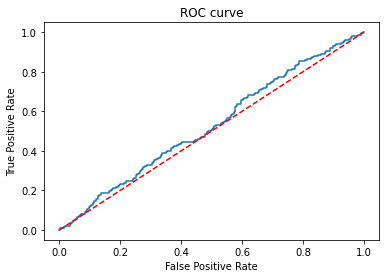

In [28]:
model1_fpr, model1_tpr, model1_thresholds = plot_roc(val_y, model1_pred_y)

In [29]:
print('AUC for model1: ', auc(model1_fpr, model1_tpr))

AUC for model1:  0.527777393900029


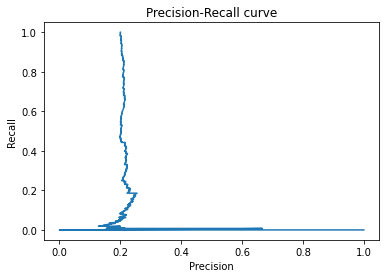

In [30]:
model1_precision, model1_recall, model1_threshold = plot_precision_recall_curve(val_y, model1_pred_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


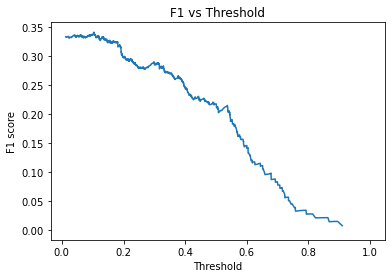

In [31]:
model1_threshold_f1, model1_f1_score = plot_f1(val_y, model1_pred_y)

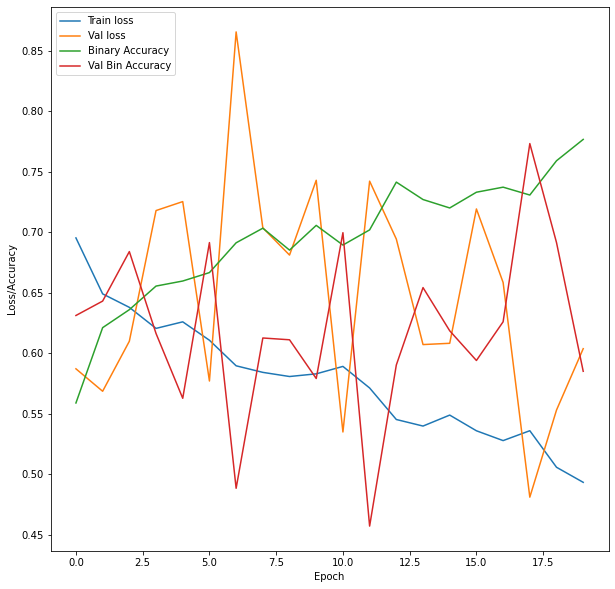

In [38]:
plot_history(model1_history)

##### Plot figures for model2

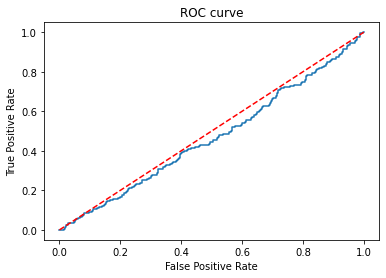

In [7]:
model2_fpr, model2_tpr, model2_thresholds = plot_roc(val_y, model2_pred_y)

In [40]:
print('AUC for model2: ', auc(model2_fpr, model2_tpr))

AUC for model2:  0.4677554207376902


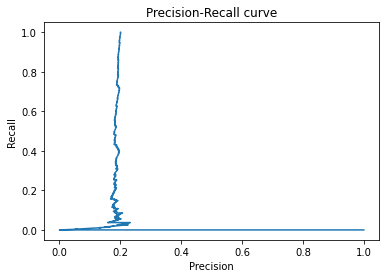

In [41]:
model2_precision, model2_recall, model2_threshold = plot_precision_recall_curve(val_y, model2_pred_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


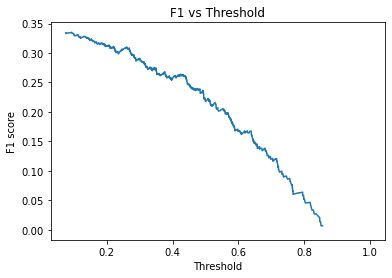

In [42]:
model2_threshold_f1, model2_f1_score = plot_f1(val_y, model2_pred_y)

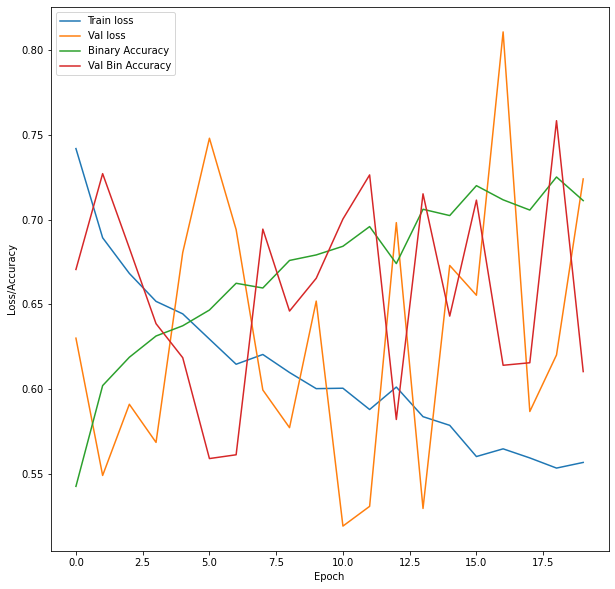

In [43]:
plot_history(model2_history)

##### Plot figures for model3

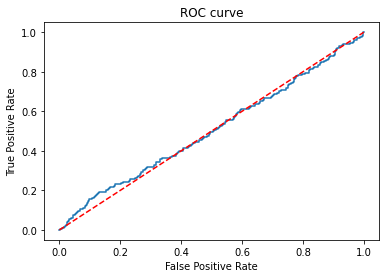

In [8]:
model3_fpr, model3_tpr, model3_thresholds = plot_roc(val_y, model3_pred_y)

In [45]:
print('AUC for model3: ', auc(model3_fpr, model3_tpr))

AUC for model3:  0.5042391619795193


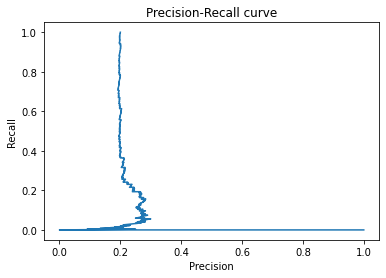

In [46]:
model3_precision, model3_recall, model3_threshold = plot_precision_recall_curve(val_y, model3_pred_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


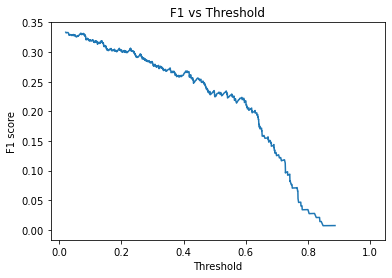

In [47]:
model3_threshold_f1, model3_f1_score = plot_f1(val_y, model3_pred_y)

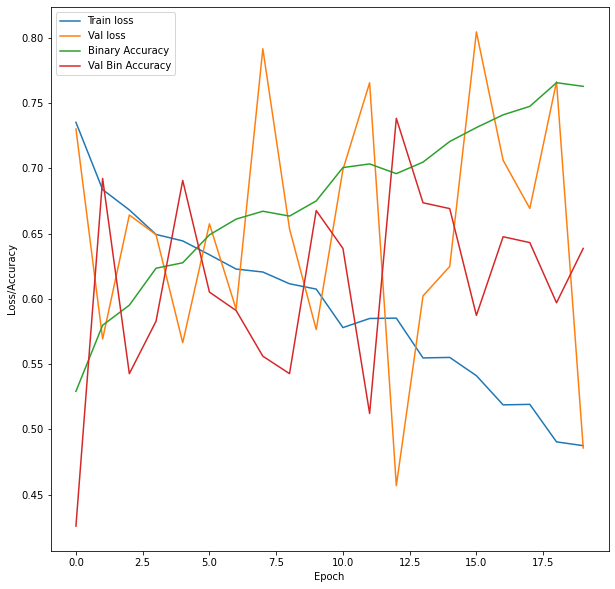

In [48]:
plot_history(model3_history)

In [49]:
model1_min_val_loss = min(model1_history['val_loss'])
model2_min_val_loss = min(model2_history['val_loss'])
model3_min_val_loss = min(model3_history['val_loss'])
print('Min validation loss of model1: ', model1_min_val_loss)
print('Min validation loss of model2: ', model2_min_val_loss)
print('Min validation loss of model3: ', model3_min_val_loss)

Min validation loss of model1:  0.48114195466041565
Min validation loss of model2:  0.5192808508872986
Min validation loss of model3:  0.4569530785083771


We can see that model3 achieved the lowest `val_loss` but model1 has best ROC AUC, so let's proceed with model1.

In [23]:
# VGG pretrained model architecture selected
load_pretrained_model().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [32]:
# Final model architecture
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [33]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def get_ROC_max_threshold(tpr, fpr, roc_threshold):
    diff1 = 0
    diff2 = 0
    max_tpr = 0
    # Find max tpr
    for i in range(len(tpr)):
        diff2 = tpr[i] - fpr[i]
        if diff2 > diff1:
            diff1 = diff2
            max_tpr = tpr[i]
            
    df = pd.DataFrame({'tpr': tpr, 'roc_threshold': roc_threshold})
    max_threshold = df[df['tpr'] == max_tpr]['roc_threshold'].iloc[-1]
    return max_threshold
    

def get_f1_max_threshold(threshold_f1, f1):
    df = pd.DataFrame({'threshold_f1': threshold_f1, 'f1': f1})
    max_threshold = df[df['f1'] == df['f1'].max()]['threshold_f1'].iloc[-1]
    return max_threshold

In [34]:
max_thresh1 = get_ROC_max_threshold(model1_tpr, model1_fpr, model1_thresholds)
print('max_thresh1: ', max_thresh1)

max_thresh1:  0.09958504140377043


In [36]:
max_thresh2 = get_f1_max_threshold(model1_threshold_f1, model1_f1_score)
print('max_thresh2: ', max_thresh2)

max_thresh2:  0.10380879044532776


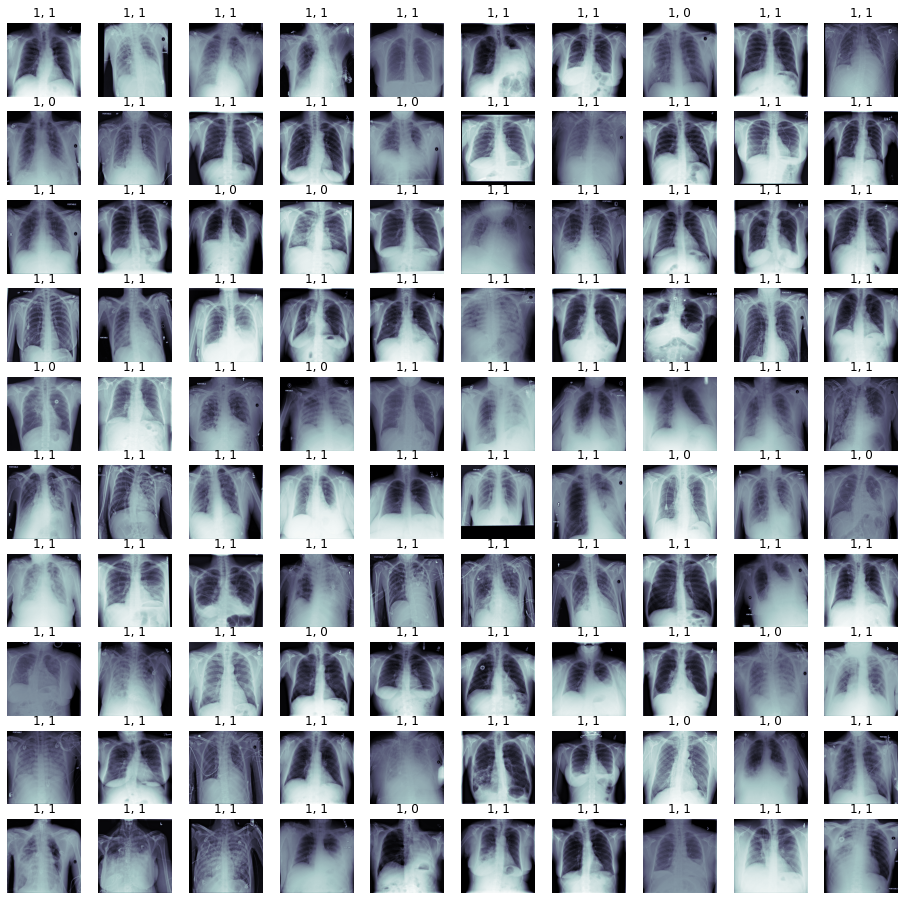

In [38]:
## Let's look at some examples of true vs. predicted with our best model: 

threshold = max_thresh1

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_x[0:100], val_y[0:100], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if model1_pred_y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if model1_pred_y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [37]:
def get_pred_y_labels_precision_and_recall(thresh, true_y, pred_y):
    pred_y_labels = []

    for y in pred_y:
        if y > thresh:
            pred_y_labels.append(1)
        else:
            pred_y_labels.append(0)
            
    return pred_y_labels, precision_score(true_y, pred_y_labels), recall_score(true_y, pred_y_labels)

In [39]:
pred_y_labels_t1, precision_t1, recall_t1 = get_pred_y_labels_precision_and_recall(max_thresh1, val_y, model1_pred_y)
tn, fp, fn, tp = confusion_matrix(val_y, pred_y_labels_t1).ravel()
print('Confusion Matrix:\n', tp, fp, '\n', tn, fn)
print('Precision with max_thresh1: ', precision_t1)
print('Recall with max_thresh1: ', recall_t1)

Confusion Matrix:
 230 868 
 208 39
Precision with max_thresh1:  0.20947176684881602
Recall with max_thresh1:  0.8550185873605948


In [44]:
# Find the F1 score at max_thresh1
2 * (precision_t1 * recall_t1) / (precision_t1 + recall_t1)

0.33650329188002925

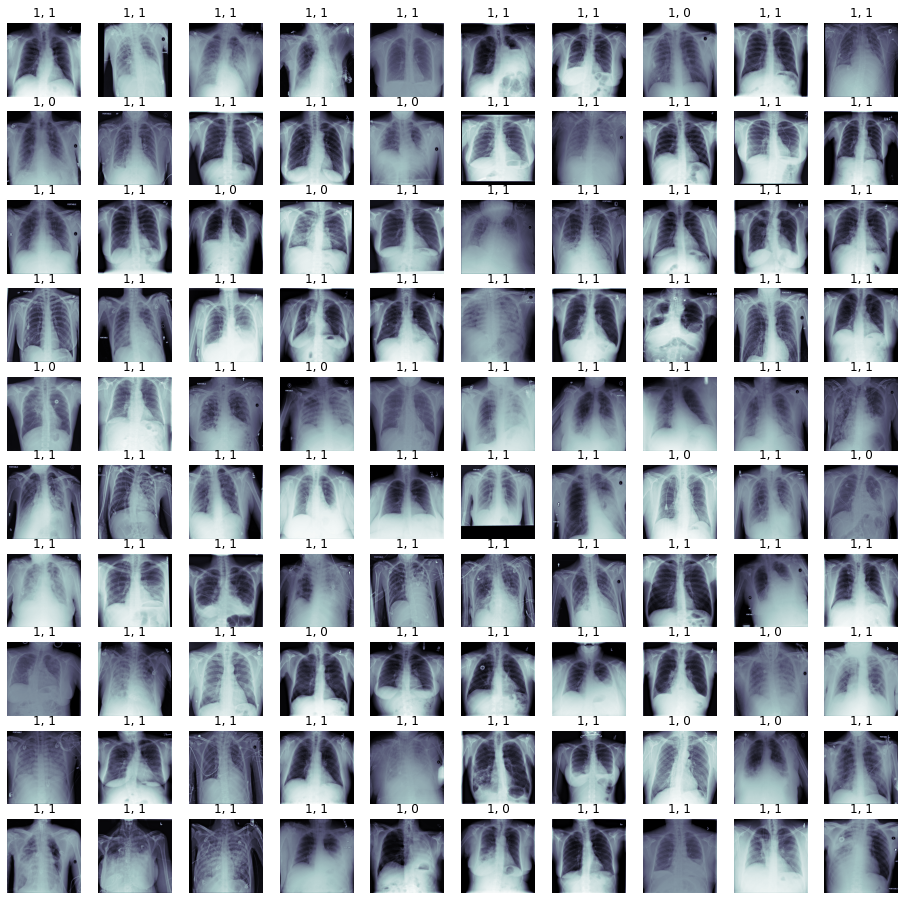

In [40]:
## Let's look at some examples of true vs. predicted with our best model: 

threshold = max_thresh2

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_x[0:100], val_y[0:100], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if model1_pred_y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if model1_pred_y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [41]:
pred_y_labels_t2, precision_t2, recall_t2 = get_pred_y_labels_precision_and_recall(max_thresh2, val_y, model1_pred_y)
tn, fp, fn, tp = confusion_matrix(val_y, pred_y_labels_t2).ravel()
print('Confusion Matrix:\n', tp, fp, '\n', tn, fn)
print('Precision with max_thresh2: ', precision_t2)
print('Recall with max_thresh2: ', recall_t2)

Confusion Matrix:
 229 848 
 228 40
Precision with max_thresh2:  0.21262766945218198
Recall with max_thresh2:  0.8513011152416357


In [42]:
# Find the max F1 score at max_thresh2
max(model1_f1_score)

0.3414996288047513

***Conclusion***:

From the above metrics, we can conclude that model1 offers the best results, with ROC AUC 0.5277, threshold at 0.1038, F1 score at 0.3415, recall at 0.8513 and precision at 0.2126.

In [43]:
# Just save model architecture to a .json:
model_json = model1.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)